# Human Activity Recognition with SmartPhones

30 participants performed activities of daily living while carring a waist-mounted smartphone. The phone was configured to record implemented sensors (accelerometer and gyroscope). For these time series the directors of the underlying study performed feature generation and generated the dataset by moving a fixed-width window of 2.56s over the series. Series the windows had 50% overlap the resulting points are equally spaced (1.28s) 

In [46]:
# import libraries
# data frame
import pandas as pd

# linear algebra
import numpy as np
from numpy import pi

# visualisation 
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
init_notebook_mode(connected = True)

# get new datatypes and functions 
from collections import Counter
from cycler import cycler

# investigate distributions 
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# machine learning 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# gbm light 
from lightgbm import LGBMClassifier

# measure time 
from time import time

print ('Ok for the libraries')

Ok for the libraries


# Load data

In [47]:
# load datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [48]:
# add the tag of train and test
df_train['Data'] = 'Train'
df_test['Data'] = 'Test'
df_all = pd.concat([df_train, df_test], axis = 0).reset_index(drop=True)

In [49]:
df_all['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

# Dataset exploration

In [50]:
df_all.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284,16.146422
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898,8.679067
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880,9.000000
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882,17.000000
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970,24.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000


In [51]:
# Group and count main names of columns (features)
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in df_all.columns])
                       , orient = 'index').rename(columns = {0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


## Mainly there are 'accelerometer' and 'gyrocscope' features. A few 'gravity' features (Mag) are there as well. 


In [52]:
# Count if there is null values in dataframe
print('Null values in dataframe: {}\n'.format(df_all.isna().sum().sum()))
df_all.info()

Null values in dataframe: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 564 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), int64(1), object(2)
memory usage: 44.3+ MB


In [53]:
df_all

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24,WALKING_UPSTAIRS,Test
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24,WALKING_UPSTAIRS,Test
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184,24,WALKING_UPSTAIRS,Test
10297,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563,24,WALKING_UPSTAIRS,Test


In [60]:
# Create label
label = df_all['Activity']
label_counts = label.value_counts()

# get colors 
n = label_count.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0,1.01, 1/(n-1))]

# create plot
data = go.Bar(x = label_counts.index,
             y = label_counts,
             marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone activity label distribution',
                  xaxis = dict(title = 'Activity'),
                  yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

# Activity exploration

## Can we separate the activities by the 'accelerometer' and 'gyrocscope' features?
The dataset is geared towards classifying the activity of the participant. Let us investigate the separability of the classes. 

In [63]:
df_all

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24,WALKING_UPSTAIRS,Test
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24,WALKING_UPSTAIRS,Test
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184,24,WALKING_UPSTAIRS,Test
10297,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563,24,WALKING_UPSTAIRS,Test


NameError: name 'get_map' is not defined

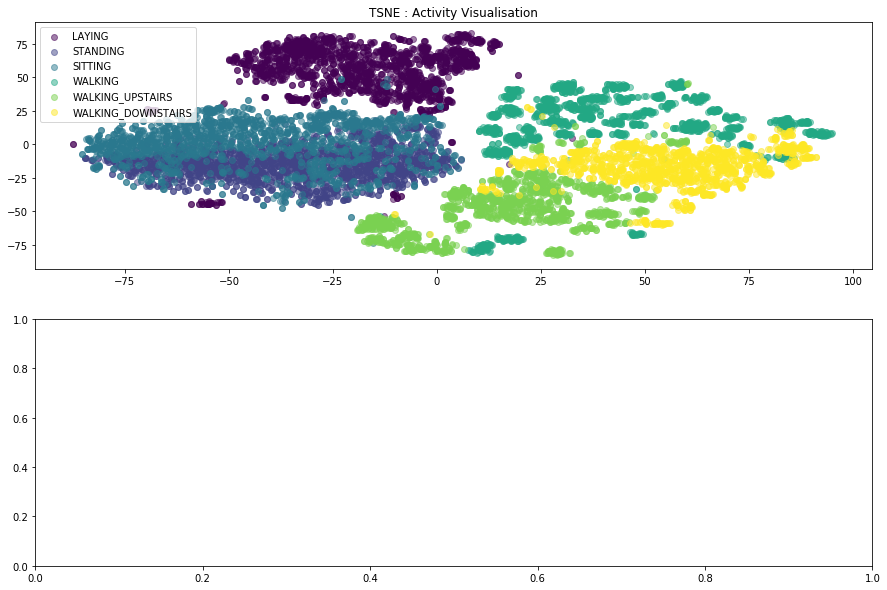

In [67]:
# separate the number and string data columns
tsne_data = df_all.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')
activity_data = tsne_data.pop('Activity')

# scale the rest numeric data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components = 0.9, random_state = 3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state = 3)
tsne_transformed = tsne.fit_transform(tsne_data)

# Create subplots
fig , axarr = plt.subplots(2, 1, figsize = (15, 10))

### plot activities
# get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0,1.01,1/(n-1))]

# plot each activity 
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label == group).values
    axarr[0].scatter (x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1],c= colors[i], alpha =0.5, label =group)
    axarr[0].set_title('TSNE : Activity Visualisation')
    axarr[0].legend()

### plot subjects 
# get colors 
n = subject_data.unique().shape[0]
colormap = get_map('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# plot each participant
for i, group in enumerate(subject_data.unique()):
    #mask to separate sets
    mask = (subject_data == group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c = colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()